# Lab 3 - RAW Image Processing #

- Understand RAW photo format.

- Explain the RAW processing workflow. Understand the kew steps in converting RAW photo into a standard RGB image.

- Implement a basic RAW Processing Pipeline

## 1. Introduction ##

### 1.1 Image Formats ###

**[JPEG](https://en.wikipedia.org/wiki/JPEG) & [HEIF](https://en.wikipedia.org/wiki/High_Efficiency_Image_File_Format) formats**
- "Ready-to-view" compressed outputs from a camera.

**Their Limitations**
- Lossy compression and non-linear processing makes them more difficult to operate with mathmatically.
- Typically have a smaller dynamic range than what the camera's sensor is capable of.

**Why RAW?**
- Direct access to unprocessed sensor data, preserving more information for better control over processing.

### 1.2 What is RAW? ###

**RAW images** is a class of computer files that contain:
- An uncompressed image of the sensor pixel values.
- A large amount of meta-information about the image generated by the camera. This metadata is often in a format called [Exif](https://en.wikipedia.org/wiki/Exif) (Exchangeable image file format)

RAW files themselves come in many proprietary file formats: Canon's .CR2, Nikon's .NEF, Apple's ProRAW

But there is a common open format by Adobe, **.DNG**, which stands for *Digital Negative*. The name indicates how these files are supposed to  be thought of by digital photographers: the master originals, repositories of all the captured information of the scene.

**RAW Data** from an image sensor

- Represents **light indensity values** captured from the scene as an **m-by-n pixel array**
- Stored as **single-channel intensity values**. Each pixel as an integer that contains 10-14 bits of data.
- There may be a non-zero minimum value to represent **'black'**.
- There is **no true white** - only values reaching **sensor saturation**.

**Color Representation in RAW**
- Sensors are laid out with respect to a **Color Filter Array (CFA)**, such as a Bayer filter pattern.
- Each pixel carries information about a single color channel: Red, Green, or Blue
- Light as number of electrons in a capacitor, and saved as scaler value.
- CFAs offer a compromise where information about each color channels are captured at different locations.

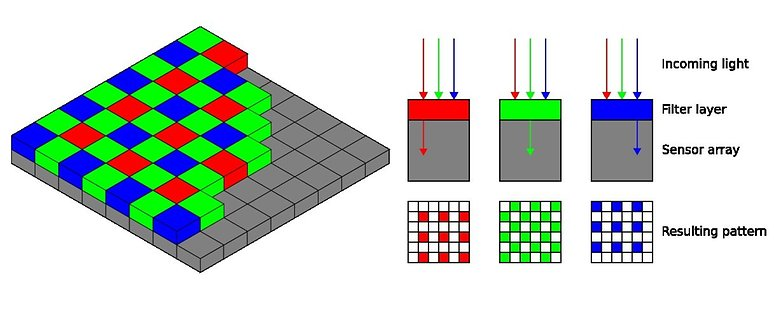

**Bayer Filter Pattern** (Above)

- The most common CFA pattern in digital cameras.
- There are twice as many pixels that represent green light because the human eye is more sensitive to variation in shades of green.
- The arrangement has each 2-by-2 block in the 'grbg' layout. To represent all three elements at every location, we must demosaic.
- Other CFA types exists, like [Fuji's X-Trans](https://en.wikipedia.org/wiki/Fujifilm_X-Trans_sensor)

### 1.3 Displaying a RAW image ###

Here is an overview of what we will explore to read and display a RAW image:
1. Extract the unprocessed CFA image out of a proprietary RAW file.
2. Apply linearization and normalization. Map raw sensor data from integers to a floating-point range [0,1].
3. White balancing to correct color casts.
4. Debayering (demosaicing) to convert the single-channel Bayer pattern into a 3-channel RGB image by interpolating missing values.
5. Convert the camera RGB image to standard RGB color space.
6. Adjust brightness and apply gamma correction.

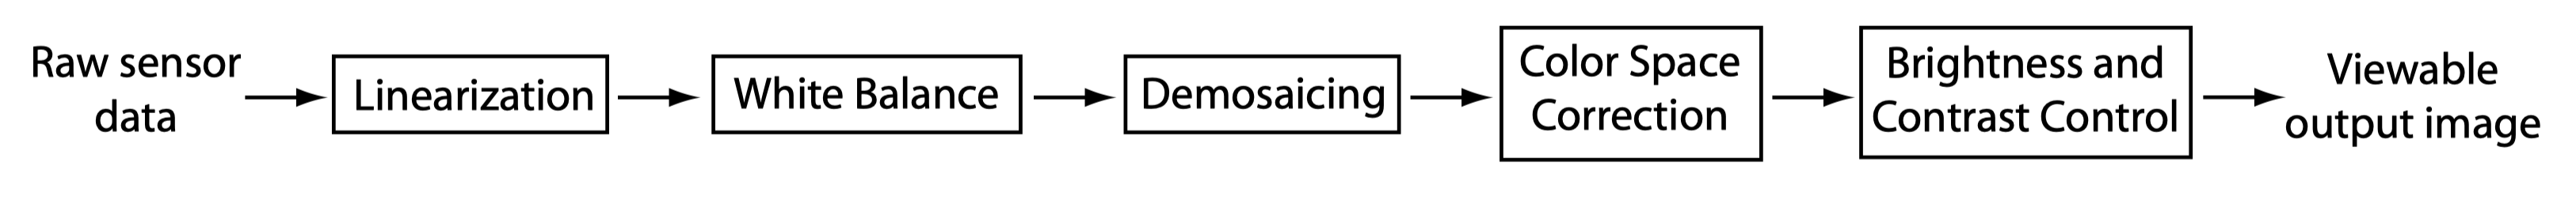

We will implement each of these steps in Python together.

## 2. Processing RAW ##

### 2.1 Extracing CFA from RAW ###

To work with raw images in Python, we must first convert the camera-manufactuer-specific formats and obtain the image data inside.

#### 2.1.1 With rawpy ####

[rawpy](https://pypi.org/project/rawpy/) is a Python wrapper for LibRaw, a powerful library for reading and processing RAW image files from digital cameras. Similar to dcraw (2.1.2), rawpy supports various camera models and proprietary RAW formats. Unlike dcraw, rawpy allows direct integration with Numpy, allowing users to manipulate RAW sensor data efficiently within Python.

Install rawpy from terminal:
```
conda activate cpsc479
pip install rawpy
```

In [1]:
# install rawpy
!pip install rawpy

   ---------------------------------------- 0.0/855.5 kB ? eta -:--:--
   ------------ --------------------------- 262.1/855.5 kB ? eta -:--:--
   ---------------------------------------- 855.5/855.5 kB 2.5 MB/s eta 0:00:00


In [2]:
import rawpy
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
dng_file_path = "sample.DNG"
tiff_file_path = "sample.tiff"

# Task1: Load the DNG with rawpy, extract CFA, save as TIFF file
with rawpy.imread(dng_file_path) as raw:
  # raw.raw_image is a 2D NumPy array of the CFA data
  cfa = raw.raw_image
  print(f"Raw image shape: {cfa.shape}")
  print(f"Raw image data type: {cfa.dtype}")

  # We can also check the range of values
  min_val, max_val = np.min(cfa), np.max(cfa)
  print(f"CFA min value: {min_val}, max value: {max_val}")

  # We can access metadata from the raw file
  print(f"Raw Pattern: \n{raw.raw_pattern}")
  print(f"Color Description: {raw.color_desc}")
  print(f"Black level per channel: {raw.black_level_per_channel}")
  print(f"White level: {raw.white_level}")
  print(f"Camera white balance: {raw.camera_whitebalance}")
  print(f"Color matrix: \n{raw.color_matrix}")

  # Save CFA data to a TIFF file so that other software (like Pillow, ImageJ, or OpenCV)
  # can read it as a single-channel 16-bit image.
  img = Image.fromarray(cfa.astype(np.uint16))
  img.save(tiff_file_path, format="TIFF")

Raw image shape: (3366, 4496)
Raw image data type: uint16
CFA min value: 339, max value: 16383
Raw Pattern: 
[[0 1]
 [3 2]]
Color Description: b'RGBG'
Black level per channel: [511, 511, 511, 511]
White level: 16000
Camera white balance: [1.6860108375549316, 1.0, 1.8248708248138428, 0.0]
Color matrix: 
[[ 1.8138168  -0.92969143  0.11587472  0.        ]
 [-0.23662259  1.6635798  -0.4269572   0.        ]
 [ 0.02182632 -0.5077259   1.4858996   0.        ]]


#### 2.1.2 With Dave Coffin's dcraw ####

Dave Coffin's [dcraw](https://www.dechifro.org/dcraw/) is a cross-platform open-source software that can read dozens of different types of RAW file and output an easily read PPM or TIFF file that Python's Pillow package can directly read data from. Many open-source image editing suites incorporate this program as their own RAW-reading routine. It can read file from hundreds of camera models and perform many standard processing steps to take a RAW file and generate an attractive output.

**Option 1: Install dcraw via Package Manager**

- **Mac:** You can install using [Homebrew](https://brew.sh/) `brew install dcraw`

- **Linux:** `sudo apt update && sudo apt install dcraw`

- **Windows:** There is no official package manager installation, but you can use pre-built binaries (see below).

**Option 2: Compile dcraw from Source**

To compile dcraw, [download the source file 'dcraw.c'](https://www.dechifro.org/dcraw/dcraw.c) from Dave Coffin's webpage and run the following command at a terminal prompt:

```
gcc -o dcraw -O4 dcraw.c -lm -DNODEPS
```

Once it's successfully compiled, you should be able to run `dcraw` to see the manual for all the available flags. Remember to use `./dcraw` (linux, Mac) or `.\dcraw` to call the executable from the shell.

**Mac:** You might have to remove the `-O4` flag to compile.

**Windows:** Build dcraw using your favourite C compiler (MinGW directly, or Visual C---[repo here for Visual Studio](https://github.com/olivierlevon/dcraw)), or use the pre-built executables from [here](https://browncsci1290.github.io/webpage/labs/raw/code/dcraw-winbuild.zip).

**Linux:** Should compile fine. Pre-built executables from [here](https://browncsci1290.github.io/webpage/labs/raw/code/dcraw-linuxbuild.zip).

**Extract information from the Exif metadata**

Run command `dcraw -4 -d -v -T <path_to_raw_file>`
- Flag `-T` asks to output a .TIFF file—a format that can store uncompressed high-bit-per-pixel (bpp) images, like a 16-bit unsigned integer.
- Flag `-4` asks to linearize the output based on known camera properties, such that e.g. an intensity value of 2x represents twice the amount of light as intensity value x.

Running dcraw will present the following formatted output:

```
Scaling with darkness <black>, saturation <white>, and multipliers <r_scale> <g_scale> <b_scale> <g_scale>
```

where integer numbers fill in the fields above. Record each of them as we will make use of these shortly.

Running `dcraw -i -v <path_to_raw_file>` will print basic metadata wiout processing the image.

**Extract CFA from RAW**

To get the raw sensor data into Python, we use dcraw with the following options to output a 16bpp TIFF file. This will also overwrite the previously produced preliminary image.

```
dcraw -4 -D -T <path_to_raw_file>
```

This will produce a .tiff file.

#### 2.1.3 CFA and Useful Metadata from RAW ####

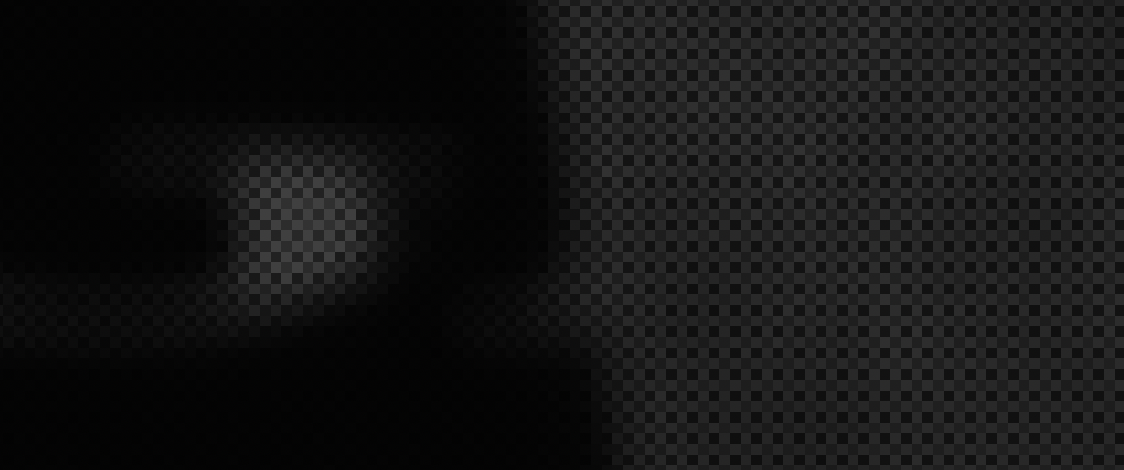

After 2.1.1 or 2.1.2, you will have a sample.tiff file in your directory with the raw CFA information of the photo. Load the file for processing.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

CFA shape: (3366, 4496)
CFA data type: float64


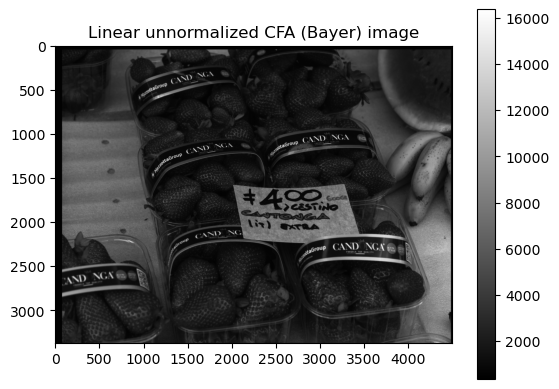

In [5]:
tiff_file_path = "sample.tiff"

# load raw data
cfa_data = Image.open(tiff_file_path)
cfa = np.array(cfa_data).astype(np.double)

print("CFA shape:", cfa.shape)
print("CFA data type:", cfa.dtype)

plt.imshow(cfa, cmap='gray')
plt.title("Linear unnormalized CFA (Bayer) image")
plt.colorbar()
plt.show()

We also extracted metadata from the image with rawpy or dcraw. These values will be useful in the processing pipeline.

```
Black level per channel: [511, 511, 511, 511]
White level: 16000
Camera white balance: [1.6860108375549316, 1.0, 1.8248708248138428, 0.0]
Color matrix:
[[ 1.8138168  -0.92969143  0.11587472  0.        ]
 [-0.23662259  1.6635798  -0.4269572   0.        ]
 [ 0.02182632 -0.5077259   1.4858996   0.        ]]
 ```

### 2.2 Linearization ###

To normalize the pixel values of the image, we need to apply an affine transformation from range [black, white] to range [0,1].

- **Black** level is the minimum dark value. Substracting this level ensures that zero in your image corresponds to "no light".

- **White** level (saturation) is the maximum raw pixel value at which the sensor saturates (cannot measure any more light). Commonly 16384 for 14-bit sensors.

In [6]:
# These values are read from the metadata
# The black point in the RAW image
black = 511
# The value at which the sensor can no longer produce any higher values
saturation = 16000

In [8]:
# the image numpy array we loaded is
image_raw = cfa  # A m-by-n array of integer in [0, 16384]
# TODO
image_linear = (image_raw - black)/(saturation - black) # A m-by-n array of double in [0, 1]

array([[-1.35580089e-03,  7.74743366e-04, -1.48492479e-03, ...,
         7.74743366e-04,  1.16211505e-03,  7.74743366e-04],
       [-3.22809736e-04, -6.45619472e-04,  6.45619472e-05, ...,
         1.61404868e-03,  6.45619472e-05,  1.22667700e-03],
       [-6.45619472e-04,  7.74743366e-04,  2.19510620e-03, ...,
         4.51933630e-04,  4.51933630e-04,  6.45619472e-05],
       ...,
       [-2.19510620e-03, -1.54948673e-03, -1.29123894e-04, ...,
         3.03441152e-03,  4.64846020e-03,  4.71302214e-03],
       [-4.51933630e-04, -1.80773452e-03,  2.32423010e-03, ...,
         4.97126993e-03,  5.48776551e-03,  4.06740267e-03],
       [-3.87371683e-04,  7.10181419e-04,  1.42036284e-03, ...,
         3.35722125e-03,  3.93827878e-03,  4.00284073e-03]])

Data range (after linearization): -0.011104654916392278 1.0247272257731292


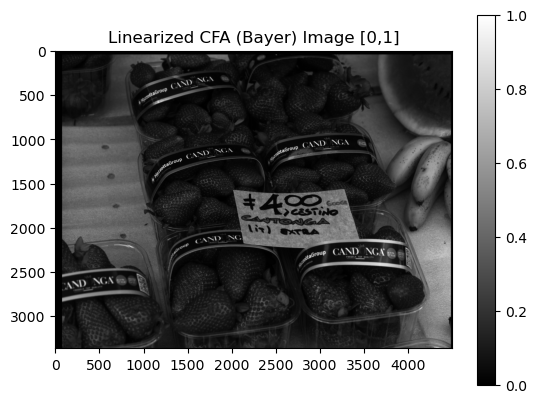

In [9]:
# Visualize image_linear
print("Data range (after linearization):", image_linear.min(), image_linear.max())

plt.title("Linearized CFA (Bayer) Image [0,1]")
plt.imshow(image_linear, cmap='gray', vmin=0, vmax=1)
plt.colorbar()
plt.show()

### 2.3 White Balancing ###

**Colors depend on illuminations:** the same object can appear different under different lighting conditions. White balance corrects for lighting color casts to make colors appear natural to human eyes.

To adjust color channels, we need a reference point, something we know should be a certain color (typically white or gray). Then we can rescale the R, G, B values of the pixel until it is that color (the reference object appears neutral).

We assume the entire scene is lit by the same light source, and applies the same correction across the image. Typically, Green is the reference channel (normalized to 1), so we simply need to find two scalars which represent the relative scaling of Red and Blue relative to Green.

These scalars are available in the metadata!


In [20]:
# White balance multipliers for each of the R, G, B channels
wb_multipliers = [1.6860108375549316, 1.0, 1.8248708248138428]

In [21]:
# Helper function that prints a 4 by 4 block of pixel values
def print_4x4(arr, title="4×4 block", start_x=400, start_y=400):
    print(f"{title} at ({start_x}, {start_y}):")
    # If 2D array: shape = (m, n)
    if arr.ndim == 2:
        block = arr[start_y:start_y+4, start_x:start_x+4]
        print(block)
    # If 3D array: shape = (m, n, c)
    elif arr.ndim == 3:
        m, n, c = arr.shape
        for ch in range(c):
            print(f"Channel {ch}:")
            block = arr[start_y:start_y+4, start_x:start_x+4, ch]
            print(block)
    else:
        print("Array has unsupported dimensions (only 2D or 3D supported).")

In [22]:
# Step 1. Turn wb_multipliers into a m-by-n mask
m, n = image_linear.shape

# We can initialize the entire array to the green multiplier (1.0) first
wb_matrix = wb_multipliers[1] * np.ones((m,n))
print_4x4(wb_matrix, "Initialized with green")

Initialized with green at (400, 400):
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]


In [23]:
# We then insert red and blue multipliers
wb_matrix[0::2, 0::2] = wb_multipliers[0]  # R  # [start:stop:step]
wb_matrix[1::2, 1::2] = wb_multipliers[2]  # B
print_4x4(wb_matrix, "RGB multipliers")

RGB multipliers at (400, 400):
[[1.68601084 1.         1.68601084 1.        ]
 [1.         1.82487082 1.         1.82487082]
 [1.68601084 1.         1.68601084 1.        ]
 [1.         1.82487082 1.         1.82487082]]


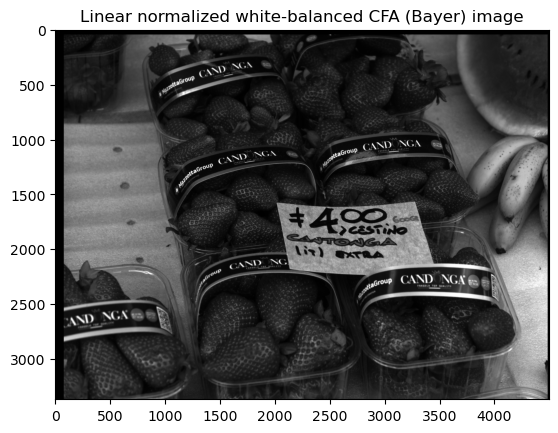

In [24]:
# Step 2. Apply the mask
image_balanced = np.multiply(image_linear, wb_matrix)

# visualize the image
plt.imshow(np.clip(image_balanced, 0, 1), cmap='gray')
plt.title("Linear normalized white-balanced CFA (Bayer) image")
plt.show()

### 2.4 Debayering (Demosaicing) ###

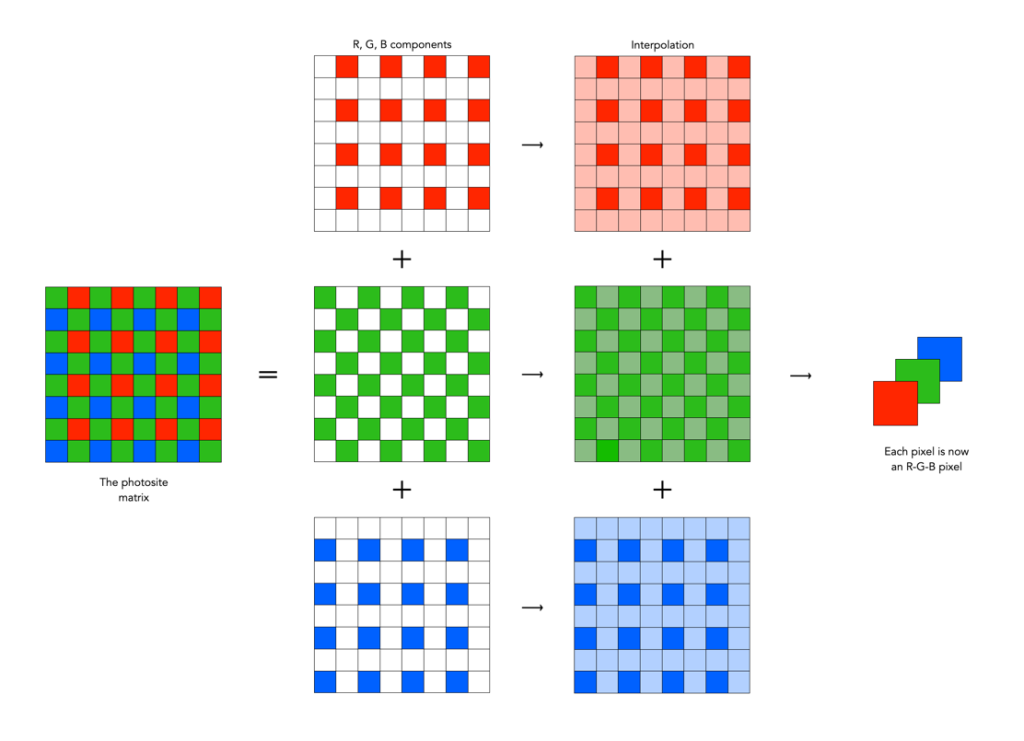

Demosaicing, also known as debayering for the Bayer pattern, is the process to convert a **CFA image (m-by-n)** to an **RGB color image (m-by-n-by-3)**. While we may only truly sample one spectral value at any pixel location, we can interpolate another two color values from nearby neighbors where those colors are not sampled.

There are various demosaic functions available. Instead of using them, we will write our own algorithm. The simplest method is linear interpolation from the nearest neighbors.

In [25]:
# Assume we have a single-channel Bayer image in 'rggb' layout:
#   R G R G
#   G B G B
#   R G R G
#   G B G B
# Convert input to double to ensure safe calculation
image_bayer = image_balanced.astype(np.double)

# Dimensions
m, n = image_bayer.shape

In [26]:
# Step 1: Separate bayer_img into three separate channels for RGB
#   R 0 R 0     0 G 0 G     0 0 0 0
#   0 0 0 0     G 0 G 0     0 B 0 B
#   R 0 R 0     0 G 0 G     0 0 0 0
#   0 0 0 0     G 0 G 0     0 B 0 B
# So later we can fill in missing data by applying small convolution filters

print_4x4(image_bayer, "Image")
# G
green_mask = np.tile([[0, 1], [1, 0]], (m // 2, n // 2))
print_4x4(green_mask, "Green Mask")
g = image_bayer * green_mask
print_4x4(g, "Green Mask Applied")

Image at (400, 400):
[[0.1269216  0.11524308 0.11375049 0.11692169]
 [0.10949706 0.10780275 0.11698625 0.11121945]
 [0.12626849 0.1186003  0.11102919 0.12525018]
 [0.11530764 0.10839184 0.11040093 0.10485732]]
Green Mask at (400, 400):
[[0 1 0 1]
 [1 0 1 0]
 [0 1 0 1]
 [1 0 1 0]]
Green Mask Applied at (400, 400):
[[0.         0.11524308 0.         0.11692169]
 [0.10949706 0.         0.11698625 0.        ]
 [0.         0.1186003  0.         0.12525018]
 [0.11530764 0.         0.11040093 0.        ]]


In [27]:
# TODO R and B
red_mask = np.tile([[1, 0], [0, 0]], (m // 2, n // 2))
print_4x4(red_mask, "Red Mask")
r = image_bayer * red_mask

blue_mask = np.tile([[0, 0], [0, 1]], (m // 2, n // 2))
print_4x4(blue_mask, "Blue Mask")
b = image_bayer * blue_mask

print_4x4(r, "Red")
print_4x4(b, "Blue")

Red Mask at (400, 400):
[[1 0 1 0]
 [0 0 0 0]
 [1 0 1 0]
 [0 0 0 0]]
Blue Mask at (400, 400):
[[0 0 0 0]
 [0 1 0 1]
 [0 0 0 0]
 [0 1 0 1]]
Red at (400, 400):
[[0.1269216  0.         0.11375049 0.        ]
 [0.         0.         0.         0.        ]
 [0.12626849 0.         0.11102919 0.        ]
 [0.         0.         0.         0.        ]]
Blue at (400, 400):
[[0.         0.         0.         0.        ]
 [0.         0.10780275 0.         0.11121945]
 [0.         0.         0.         0.        ]
 [0.         0.10839184 0.         0.10485732]]


In [28]:
# Step 2. Fill in missing pixels

# We'll define some helper filters:
# For the green channel, a cross pattern:
filter_g = 0.25 * np.array([
    [0,1,0],
    [1,0,1],
    [0,1,0]
])

# For blue (and similarly red) we do a 2-step fill with diagonal + orthogonal patterns:
filter_diag = 0.25 * np.array([
    [1,0,1],
    [0,0,0],
    [1,0,1]
])

filter_orth = 0.25 * np.array([
    [0,1,0],
    [1,0,1],
    [0,1,0]
])

In [31]:
from scipy.signal import convolve2d

# Why this works? Sketch a 5 by 5 image and work out the math.
# We'll ignore the boundary for now.

# G
print_4x4(g, "Green")
missing_g = convolve2d(g, filter_g, mode='same')
g_filled = g + missing_g
print_4x4(g_filled, "Green Filled")

# B
missing_b1 = convolve2d(b, filter_diag, mode='same')
b_step1    = b + missing_b1
missing_b2 = convolve2d(b_step1, filter_orth, mode='same')
b_filled   = b_step1 + missing_b2

# TODO R
missing_r1 = convolve2d(r, filter_diag, mode='same')
r_step1 = r + missing_r1
missing_r2 = convolve2d(r_step1, filter_orth, mode='same')
r_filled = r_step1 + missing_r2

Green at (400, 400):
[[0.         0.11524308 0.         0.11692169]
 [0.10949706 0.         0.11698625 0.        ]
 [0.         0.1186003  0.         0.12525018]
 [0.11530764 0.         0.11040093 0.        ]]
Green Filled at (400, 400):
[[0.11472658 0.11524308 0.11340306 0.11692169]
 [0.10949706 0.11508167 0.11698625 0.12441087]
 [0.11293499 0.1186003  0.11780941 0.12525018]
 [0.11530764 0.11508167 0.11040093 0.12452386]]


Demosaiced RGB shape: (3366, 4496, 3)


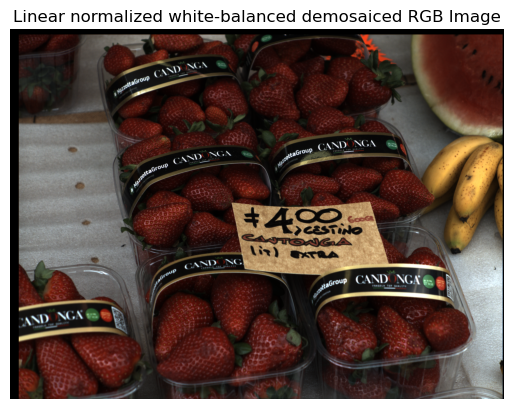

In [32]:
# Step 3. Combine channels into RGB
image_rgb = np.stack((r_filled, g_filled, b_filled), axis=2)
print("Demosaiced RGB shape:", image_rgb.shape)

plt.title("Linear normalized white-balanced demosaiced RGB Image")
plt.imshow(np.clip(image_rgb, 0, 1))
plt.axis('off')
plt.show()

### 2.5 Color Space Correction ###

Although the current RGB image is viewable with matplotlib, the color looks off, because its pixels do not have coordinates in the correct RGB space that is expected by the operating system.

We need to transform it from the **camera's color space** to the **standard RGB (sRGB)** color space by applying a 3x3 matrix transformation to each of the pixels. The camera's colors are defined with an color space called CIE XYZ, which has special properties that make it useful as a device-independent (camera independent) color space.



In [33]:
def apply_cmatrix(img, cmatrix):
    # Applies color transformation CMATRIX to RGB input IM.
    # Finds the appropriate weighting of the old color planes to form the new color planes,
    # equivalent to but much more efficient than applying a matrix transformation to each pixel.
    if (img.shape[2] != 3):
        raise ValueError('Apply cmatrix to RGB image only.')

    r = cmatrix[0,0] * img[:,:,0] + cmatrix[0,1] * img[:,:,1] + cmatrix[0,2] * img[:,:,2]
    g = cmatrix[1,0] * img[:,:,0] + cmatrix[1,1] * img[:,:,1] + cmatrix[1,2] * img[:,:,2]
    b = cmatrix[2,0] * img[:,:,0] + cmatrix[2,1] * img[:,:,1] + cmatrix[2,2] * img[:,:,2]
    corrected = np.stack((r,g,b), axis=2)
    return corrected

rgb2cam matrix:
 [[6.45972712e-01 3.28442274e-01 2.55850143e-02]
 [3.54684396e-02 9.38261579e-01 2.62699815e-02]
 [5.85661162e-04 3.87902993e-02 9.60624040e-01]]
cam2rgb matrix:
 [[ 1.57835287e+00 -5.51394286e-01 -2.69585831e-02]
 [-5.97059191e-02  1.08786535e+00 -2.81594304e-02]
 [ 1.44867340e-03 -4.35921761e-02  1.04214350e+00]]


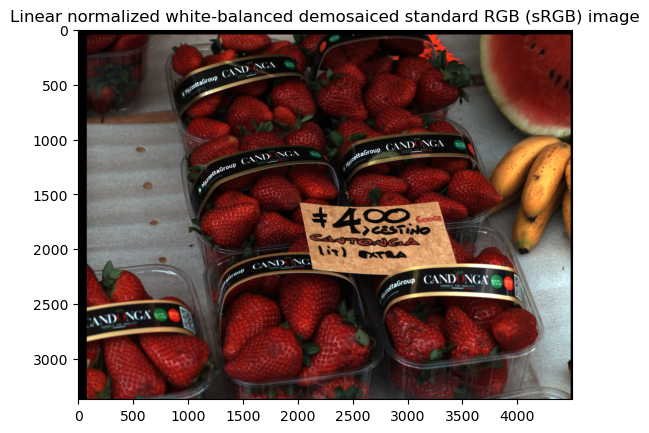

In [34]:
# Convert to sRGB

# Standard sRGB -> XYZ matrix
rgb2xyz = np.array([[0.4124564, 0.3575761, 0.1804375],
            [0.2126729, 0.7151522, 0.0721750],
            [0.0193339, 0.1191920, 0.9503041]])

# cam -> xyz matrix is embedded in metadata, it is provided by the camera
cam2xyz = [[1.8138168,  -0.92969143,  0.11587472],
          [-0.23662259, 1.6635798, -0.4269572],
          [0.02182632, -0.5077259, 1.4858996]]

# xyz -> cam
xyz2cam = np.linalg.inv(cam2xyz)

# srgb -> xyz -> cam
rgb2cam = xyz2cam * rgb2xyz

# Normalize the rows of rgb2cam so each row sums to 1
denom = np.tile(np.reshape(np.sum(rgb2cam,axis=1),(3,-1)), (1,3))
rgb2cam = np.divide(rgb2cam, denom)

# Invert to get cam2rgb (camera->sRGB)
cam2rgb = np.linalg.inv(rgb2cam)

print("rgb2cam matrix:\n", rgb2cam)
print("cam2rgb matrix:\n", cam2rgb)

# Convert from camera RGB to sRGB
image_srgb = apply_cmatrix(image_rgb, cam2rgb)
# Clip to [0,1] to avoid negative or >1 values
image_srgb = np.clip(image_srgb, 0, 1)

plt.imshow(image_srgb)
plt.title("Linear normalized white-balanced demosaiced standard RGB (sRGB) image")
plt.show()

### 2.6 Brightness and Gamma Correction ###

We now have a 16-bit, RGB image that has been color corrected and exists in the right color space for display. But the image appears too dark for human perception.

Why? Camera sensors capture **linear light values**, while human vision perceives light **non-linearly**.

To make the image visually pretty, we apply brightness and gamma correction. This is a somewhat subjective process.

**Brightness Correction**

Here we apply a simple method: Scale the image so that mean luminance is 1/4 of the maximum.

Current Mean:  0.24609103370332264
Scale Factor:  1.4222378625934302


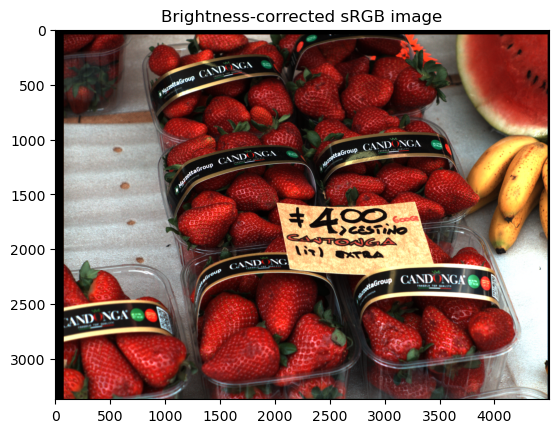

In [35]:
# TODO
# Change target_mean to adjust brightness
target_mean = 0.35 # 0.25
current_mean = np.mean(image_srgb)
scale_factor = target_mean / (current_mean + 1e-8)
image_brightness = image_srgb * scale_factor
print("Current Mean: ", current_mean)
print("Scale Factor: ", scale_factor)

plt.imshow(np.clip(image_brightness, 0, 1))
plt.title("Brightness-corrected sRGB image")
plt.show()

**Gamma Correction**

The image is now brighter, but dark areas are still too dark. We will apply a non-linear function through exponentiation to the brightness values. This is called [gamma correction](https://en.wikipedia.org/wiki/Gamma_correction), which makes use of a [power law](https://en.wikipedia.org/wiki/Power_law) to affect the brightness.

We apply a power law transformation:

$O = \alpha I^{\gamma}$.

Where:

- $I$ is the input image (linear values)
- $O$ is the output image (gamma-corrected)
- $\alpha$ is a scalling factor, usually set to 1
- The exponent $\gamma$ controls brightness perception and is arbitrary.


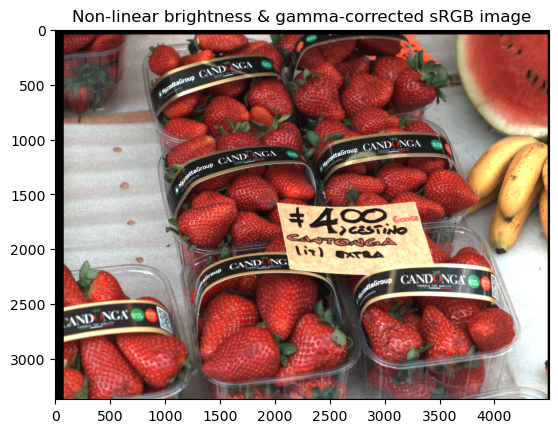

In [37]:
# TODO
# Experiment with gamma value
gamma = 0.7 # 1 / 2.2
alpha = 1.0

# TODO
image_gamma = alpha * np.power(image_brightness, gamma)

plt.imshow(np.clip(image_gamma, 0, 1))
plt.title("Non-linear brightness & gamma-corrected sRGB image")
plt.show()

### 2.7 Save Final Result ###

In [38]:
jpg_file_path = "sample.jpg"
image_processed = (image_gamma * 255).clip(0, 255).astype(np.uint8)

img = Image.fromarray(image_processed)
img.save(jpg_file_path, format="JPEG")